In [1]:
pip install TwitterAPI

  Created wheel for TwitterAPI: filename=TwitterAPI-2.7.11-py3-none-any.whl size=14194 sha256=e80f570d4620943c5405675bf97f8eaf14bb85e3150b0b1ab8f5ead41d7eb146
  Stored in directory: c:\users\cathy\appdata\local\pip\cache\wheels\e6\b7\ab\cf860d5989d3d70003ab3d71bd240214ceb80bd9e8b5c47409
Successfully built TwitterAPI
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [1]:
from TwitterAPI import TwitterAPI
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import sys
import time

In [2]:
consumer_key = 'seGChfIip0JCRqB7FzC9PRZal'
consumer_secret = 'OCKXC4PpQyY7qDYFeNXJgCZWAlAxr5MfqaeEScKQEGsXSR9WCd'
access_token = '1486887102688153606-hRE2mvmZWmYYREXyBAuWPAArjWSaEh'
access_token_secret = 'X1XGdeD7jy6AlNH9TEcBdEamOCdUFdPbSREJZJeuGB7Po'

In [3]:
def get_twitter():
    return TwitterAPI(consumer_key, consumer_secret, access_token, access_token_secret)
twitter = get_twitter()

In [4]:
usernames=[]
with open('usernames.txt', 'r') as file:
    for line in file:
        usernames.append(line.strip())
file.close() 
print('Account names: %s' % usernames)

Account names: ['tkelce', 'cheetah', '_Bigmikee1', 'Mathieu_Era', 'aokafor57', 'StoneColdJones', 'Demarcus', 'MecoleHardman4', 'PatrickMahomes']


In [5]:
def robust_request(twitter, resource, params, max_tries=5):
    for i in range(max_tries):
        request = twitter.request(resource, params)
        if request.status_code == 200:
            return request
        else:
            print('Got error %s \nsleeping for 15 minutes.' % request.text)
            sys.stderr.flush()
            time.sleep(61 * 15)

In [94]:
def get_users(twitter, usernames):
    user_request = robust_request(twitter,'users/lookup', {'screen_name':usernames})
    return user_request
users = sorted(get_users(twitter, usernames), key=lambda x: x['screen_name'])
print('%d users with usernames %s' % (len(users), str([u['screen_name'] for u in users])))

9 users with usernames ['Demarcus', 'Mathieu_Era', 'MecoleHardman4', 'PatrickMahomes', 'StoneColdJones', '_Bigmikee1', 'aokafor57', 'cheetah', 'tkelce']


In [7]:
def get_friends(twitter, usernames):
    a=[]
    friend_request = robust_request(twitter,'friends/ids', {'screen_name':usernames})
    for request in friend_request:
        a.append(request)
    return sorted(a)

In [8]:
def friends(twitter, users):  
    for u in users:
        u['friends']=get_friends(twitter, u['screen_name'])
        print('%s : %d'%(u['screen_name'],len(u['friends'])))

In [9]:
# Number of accounts followed by the players
friends(twitter, users)

Demarcus : 197
Mathieu_Era : 858
MecoleHardman4 : 376
PatrickMahomes : 490
StoneColdJones : 921
_Bigmikee1 : 500
aokafor57 : 263
cheetah : 246
tkelce : 1317


In [10]:
def common_friends(users):
    common_friends=Counter()
    for u in users:
        common_friends.update(u['friends'])
    return common_friends

In [11]:
# Finding the users who are the most common friends among the 9 players. Here account ID 19426551 is followed by 8 players.
friend_common = common_friends(users)
print('Most common friends:\n%s' % str(friend_common.most_common(10)))

Most common friends:
[(19426551, 8), (1064042478, 8), (312419427, 7), (324476933, 7), (427943780, 7), (489732610, 7), (789959876, 7), (3316535370, 7), (903344249697075200, 7), (33583496, 6)]


In [12]:
def overlap_friends(users):
    overlap=[]
    for u in range(len(users)):
        for v in range(u+1, len(users)):
            user1= users[u]['screen_name']
            user2= users[v]['screen_name']
            user_1=set(users[u]['friends'])
            user_2=set(users[v]['friends'])
            N= len(user_1.intersection(user_2))
            overlap.append((user1,user2,N))
    overlap.sort(key = lambda x:x[2], reverse = True)               
    return overlap

In [13]:
#Finding number of accounts that overlap with two players 
print('Number of friends that Overlap between two players:\n%s' % str(overlap_friends(users)))

Number of friends that Overlap between two players:
[('Mathieu_Era', 'PatrickMahomes', 136), ('PatrickMahomes', 'tkelce', 131), ('Mathieu_Era', 'tkelce', 123), ('Mathieu_Era', 'StoneColdJones', 94), ('StoneColdJones', 'tkelce', 91), ('Mathieu_Era', 'MecoleHardman4', 82), ('Mathieu_Era', 'cheetah', 72), ('cheetah', 'tkelce', 71), ('PatrickMahomes', 'StoneColdJones', 70), ('PatrickMahomes', 'cheetah', 65), ('MecoleHardman4', 'tkelce', 54), ('MecoleHardman4', 'PatrickMahomes', 51), ('StoneColdJones', 'cheetah', 51), ('MecoleHardman4', 'StoneColdJones', 48), ('Demarcus', 'Mathieu_Era', 45), ('Demarcus', 'tkelce', 42), ('Demarcus', 'PatrickMahomes', 38), ('MecoleHardman4', 'cheetah', 38), ('Demarcus', 'StoneColdJones', 36), ('Mathieu_Era', '_Bigmikee1', 35), ('Demarcus', 'MecoleHardman4', 33), ('Demarcus', 'cheetah', 31), ('PatrickMahomes', '_Bigmikee1', 22), ('_Bigmikee1', 'tkelce', 22), ('_Bigmikee1', 'cheetah', 20), ('MecoleHardman4', '_Bigmikee1', 18), ('StoneColdJones', '_Bigmikee1', 1

In [16]:
def graph(users, friend_common):
    graph = nx.Graph()
    for u in users:
        graph.add_node(u['screen_name'])
        for friend in u['friends']:
            if friend_common[friend]>1:
                graph.add_node(str(friend))
                graph.add_edge(u['screen_name'],str(friend))
    return graph

In [17]:
graph = graph(users, friend_common)
print('graph has %s nodes and %s edges' % (len(graph.nodes()), len(graph.edges())))

graph has 481 nodes and 1329 edges


In [95]:
def draw(graph, users, filename):
    list1=[]
    plt.figure(figsize=(25,25))
    plt.axis('off')
    for u in users:
        lis=u['screen_name']
        list1.append(lis)
    lab={la: la for la in list1}
    nx.draw_networkx(graph, labels=lab, node_color='red', alpha =.5,node_size = 100, edge_color ='black', with_labels=True)
    plt.savefig(filename)

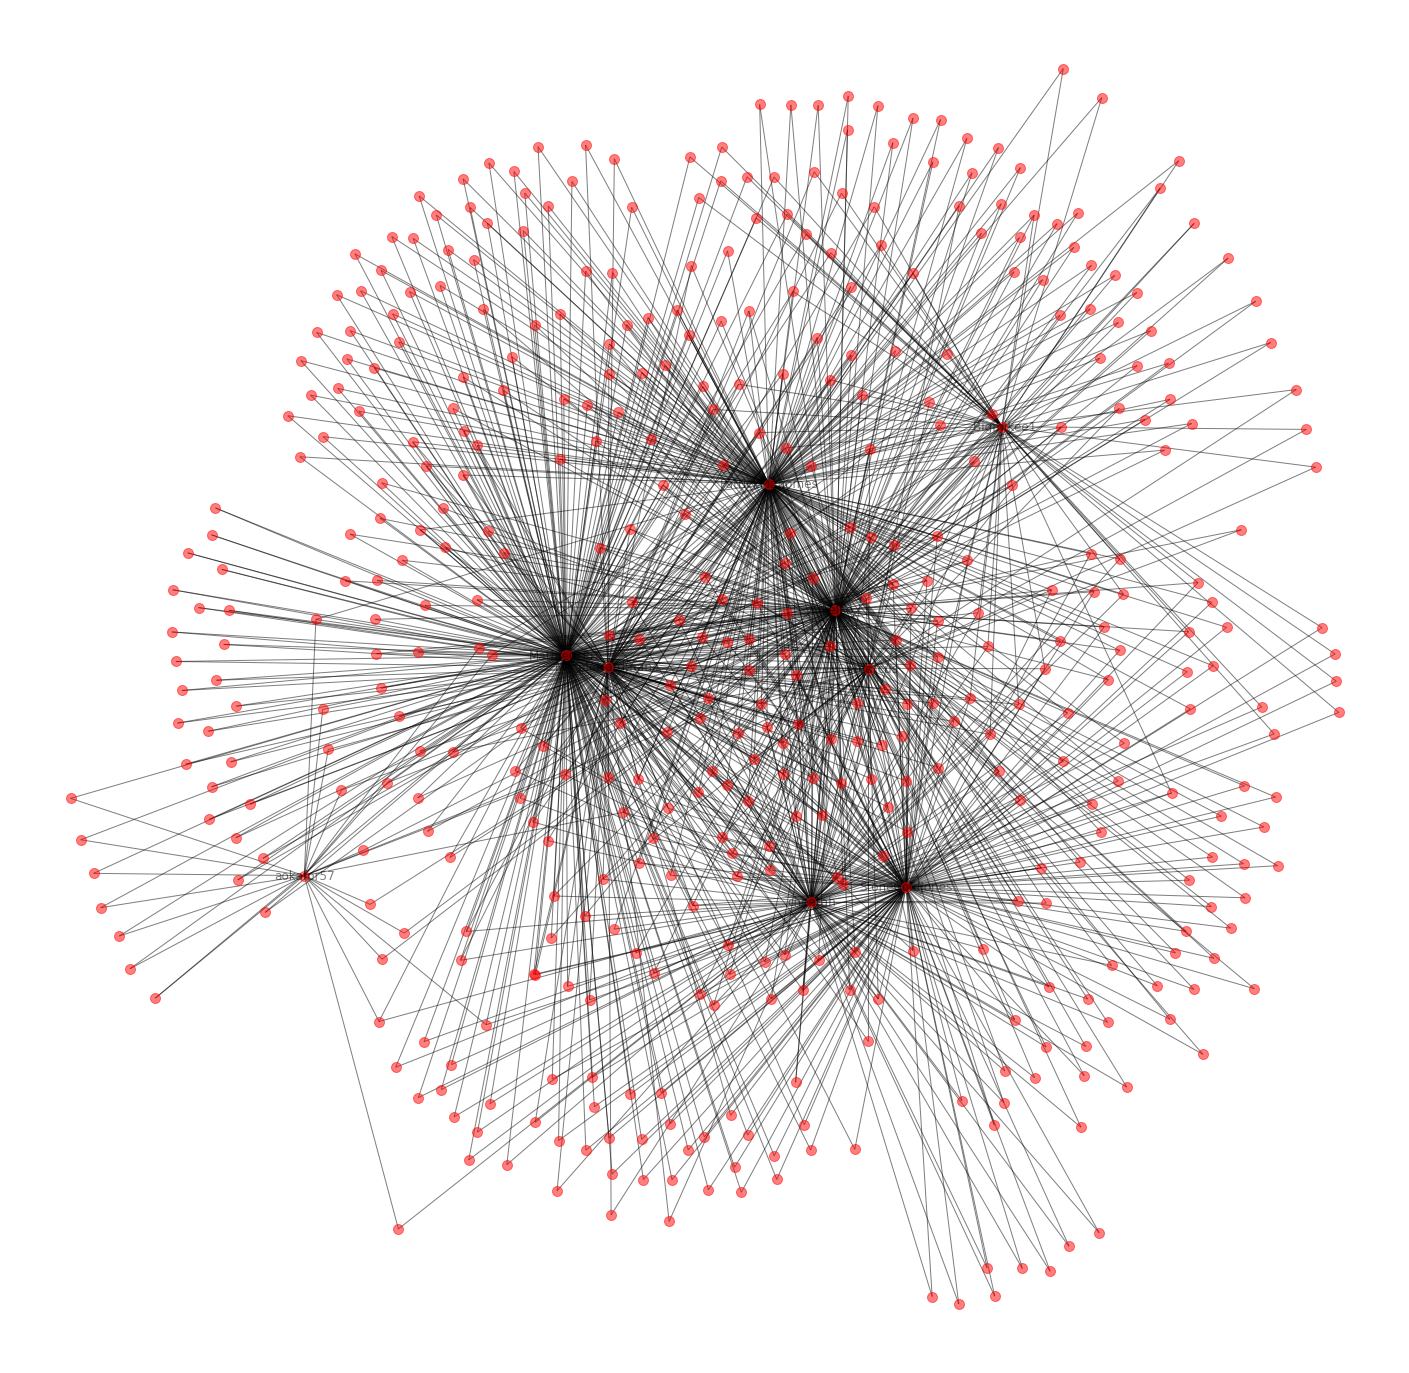

In [97]:
draw(graph, users, 'Graph network.png')

In [20]:
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 481
Number of edges: 1329
Average degree:   5.5260


DEGREE

The degree of each node (usernames) is calculated using nx.degree functionality. Degree of a node defines the number of connections of each node.

In [23]:
degree = nx.degree(graph)
for i in usernames:
    print ('Degree of %s: %d'  % (i,degree[i]))

Degree of tkelce: 242
Degree of cheetah: 132
Degree of _Bigmikee1: 68
Degree of Mathieu_Era: 287
Degree of aokafor57: 24
Degree of StoneColdJones: 161
Degree of Demarcus: 67
Degree of MecoleHardman4: 123
Degree of PatrickMahomes: 225


DEGREE DISTRIBUTION HISTOGRAM

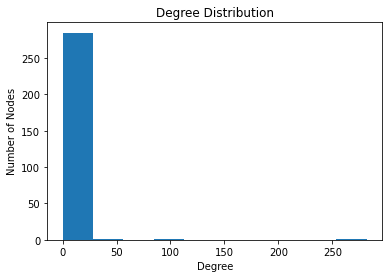

In [92]:
# nx.degree_histogram function is used to find the degree distribution of the nodes in the network
plt.hist(nx.degree_histogram(graph))
plt.title('Degree Distribution' )
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.show()

In [113]:
def plot_degree_dist(G):
    degrees = G.degree()
    degrees = dict(degrees)
    values = sorted(set(degrees.values()))
    histo = [list(degrees.values()).count(x) for x in values]
    P_k = [x / G.order() for x in histo]
    
    plt.figure()
    plt.plot(values, P_k, "ro-")
    plt.xlabel("k")
    plt.ylabel("p(k)")
    plt.title("Degree Distribution")
    plt.show()
    
    """"Plot of the histogram degree distribution""" 
    plt.figure()
    degrees = [G.degree(n) for n in G.nodes()]
    counts = dict()
    for i in degrees:
        counts[i] = counts.get(i, 0) + 1
    axes = plt.gca()
    axes.set_xlim([0,80])
    axes.set_ylim([0,500])
    plt.grid(False)
    plt.bar(list(counts.keys()), counts.values(), color='r')
    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.show()

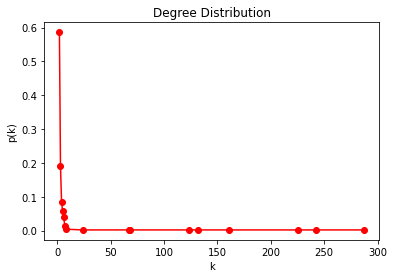

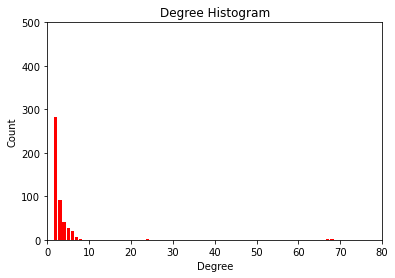

In [114]:
plot_degree_dist(graph)

SHORTEST DISTANCE

Here, we have selected @tkelce as the source node and found the shortest paths from this source node to the other nodes using the nx.shortest_path function of networkX.

In [24]:
nx.shortest_path(graph, 'tkelce', 'cheetah')

['tkelce', '19362299', 'cheetah']

In [25]:
nx.shortest_path(graph, 'tkelce', '_Bigmikee1')

['tkelce', '19362299', '_Bigmikee1']

In [26]:
nx.shortest_path(graph, 'tkelce', 'Mathieu_Era')

['tkelce', '15537451', 'Mathieu_Era']

In [27]:
nx.shortest_path(graph, 'tkelce', 'aokafor57')

['tkelce', '14594844', 'aokafor57']

In [83]:
nx.shortest_path(graph, 'tkelce', 'StoneColdJones')

['tkelce', '16216891', 'StoneColdJones']

In [84]:
nx.shortest_path(graph, 'tkelce', 'Demarcus')

['tkelce', '19426551', 'Demarcus']

In [85]:
nx.shortest_path(graph, 'tkelce', 'MecoleHardman4')

['tkelce', '19426551', 'MecoleHardman4']

In [86]:
nx.shortest_path(graph, 'tkelce', 'PatrickMahomes')

['tkelce', '14279256', 'PatrickMahomes']

ECCENTRICITY

Eccenticity is defined as the largest distance from one source node to all the other nodes and is calculated using nx.eccentricity function of networkX.

In [52]:
eccentricity = nx.eccentricity(graph)
for i in usernames:
    print ('Eccentricity of %s: %d'  % (i,eccentricity[i]))

Eccentricity of tkelce: 3
Eccentricity of cheetah: 3
Eccentricity of _Bigmikee1: 3
Eccentricity of Mathieu_Era: 3
Eccentricity of aokafor57: 3
Eccentricity of StoneColdJones: 3
Eccentricity of Demarcus: 3
Eccentricity of MecoleHardman4: 3
Eccentricity of PatrickMahomes: 3


# NETWORK MEASURES

CENTRALITY MEASURES are used to find the most important nodes(username) in the network. It helps to identify popular and biggest influencer in the network. And there are different types of centrality measures which can be calcualted using networkx

1. DEGREE CENTRALITY

It is a measure of number of connections of a node and is based on a fact that important nodes have many connections. Degree_centrality is a function in networkX to calculate this metric.

In [88]:
centrality=nx.degree_centrality(graph)
for i in usernames:
    print ('Centrality of %s:'  % (i))
    print(centrality[i])

Centrality of tkelce:
0.5041666666666667
Centrality of cheetah:
0.275
Centrality of _Bigmikee1:
0.14166666666666666
Centrality of Mathieu_Era:
0.5979166666666667
Centrality of aokafor57:
0.05
Centrality of StoneColdJones:
0.33541666666666664
Centrality of Demarcus:
0.13958333333333334
Centrality of MecoleHardman4:
0.25625
Centrality of PatrickMahomes:
0.46875


According to degree centrality function, @Mathieu_Era has the higest centrality and thus is considered popular.

2. CLOSENESS CENTRALITY

A centrality measure where each node's importance is determined by closeness of one node to all the other nodes. THe function used here is nx.closeness_centrality

In [69]:
def closeness (usernames):
    closeness = nx.closeness_centrality(graph)
    for i in usernames:
        print ('Closeness of %s:'  % (i))
        print(closeness[i])
closeness(usernames)

Closeness of tkelce:
0.5063291139240507
Closeness of cheetah:
0.410958904109589
Closeness of _Bigmikee1:
0.37037037037037035
Closeness of Mathieu_Era:
0.5594405594405595
Closeness of aokafor57:
0.3468208092485549
Closeness of StoneColdJones:
0.43243243243243246
Closeness of Demarcus:
0.3697996918335901
Closeness of MecoleHardman4:
0.40472175379426645
Closeness of PatrickMahomes:
0.48879837067209775


@Mathieu_Era remains the most popular infuencer in the network while considering the closeness centrality.

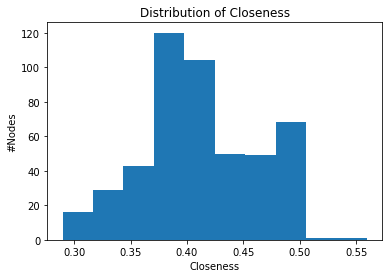

In [70]:
plt.hist(nx.closeness_centrality(graph).values())
plt.title('Distribution of Closeness' )
plt.xlabel('Closeness')
plt.ylabel('#Nodes')
plt.show()

3. BETWEENNESS CENTRALITY

It is the centrality of control and it represents the frequency at which a point occurs on the shortest paths that connected pair of points. The nodes with high betweenness centrality play a significant role in the communication flow within the network. The nodes with high betweenness centrality can have a strategic control and influence on others. An individual at such a strategic position can influence the whole group, by either withholding or coloring the information in transmission.

Networkx has the function betweenness_centrality() to measure it for the network with options to be normalized or not, weights to be included in centrality calculation or not, and to include the endpoints in the shortest path counts or not.

In [71]:
def betweenness (usernames):
    betweenness = nx.betweenness_centrality(graph)
    for i in usernames:
        print ('Betweenness of %s:'  % (i))
        print(betweenness[i])
betweenness(usernames)

Betweenness of tkelce:
0.26859310965095895
Betweenness of cheetah:
0.09177078503602158
Betweenness of _Bigmikee1:
0.03362694912210269
Betweenness of Mathieu_Era:
0.3789231012631995
Betweenness of aokafor57:
0.0036207630917081987
Betweenness of StoneColdJones:
0.12600658939432938
Betweenness of Demarcus:
0.02602254492608968
Betweenness of MecoleHardman4:
0.08020501317972678
Betweenness of PatrickMahomes:
0.21215146444720553


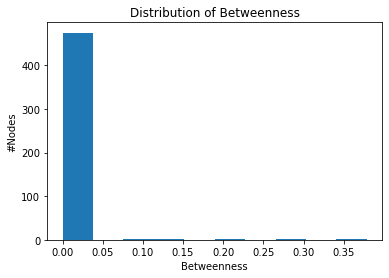

In [73]:
plt.hist(nx.betweenness_centrality(graph, normalized = True).values())
plt.title('Distribution of Betweenness' )
plt.xlabel('Betweenness')
plt.ylabel('#Nodes')
plt.show()

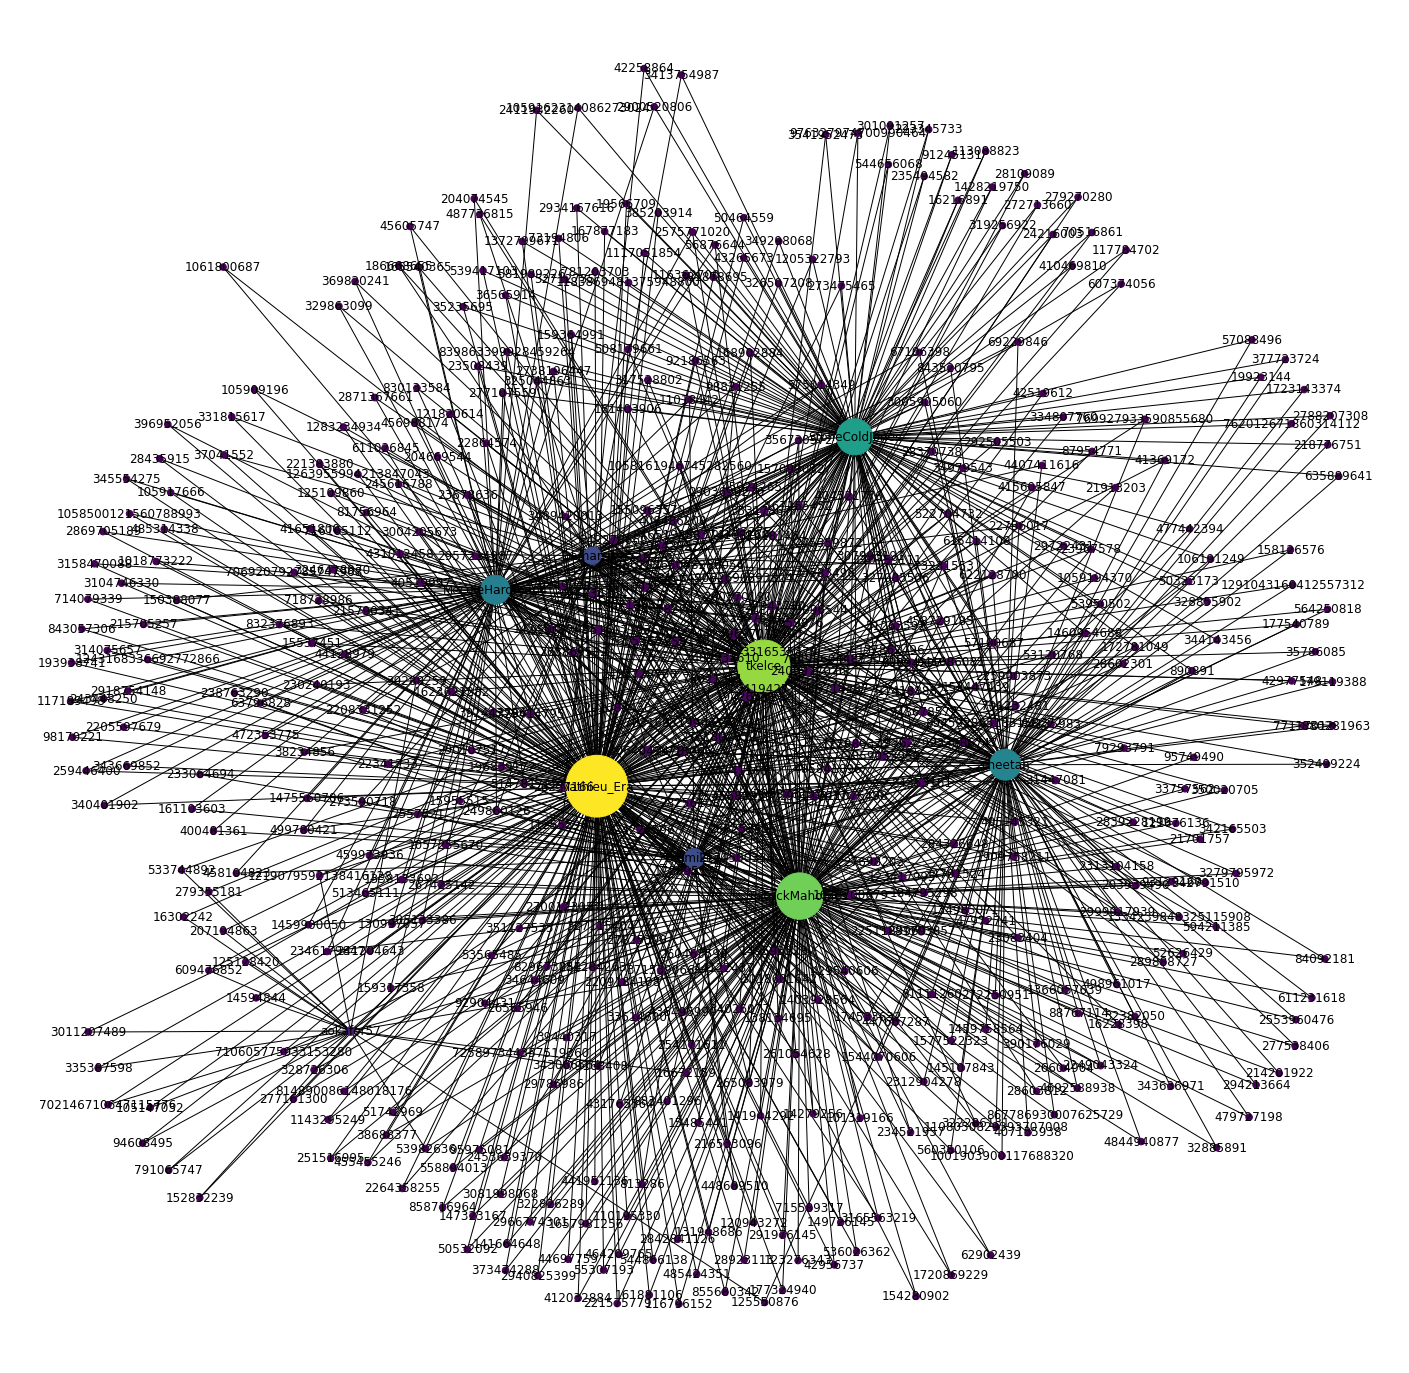

In [75]:
pos = nx.spring_layout(graph)
betCent = nx.betweenness_centrality(graph, normalized=True, endpoints=True)
node_color = [20000.0 * graph.degree(v) for v in graph]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(25,25))
nx.draw_networkx(graph, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off');

In [89]:
# These are the top 5 players with high betweenness centrality
sorted(betCent, key=betCent.get, reverse=True)[:5]

['Mathieu_Era', 'tkelce', 'PatrickMahomes', 'StoneColdJones', 'cheetah']

Thus, from all the above measures of centrality, @Mathieu_Era has the highest centrality in the network.